In [1]:

import numpy as np

import ngsolve 
from ngsolve.webgui import Draw
import netgen.geom2d

# some helpful websites on ngsolve

https://docu.ngsolve.org/latest/index.html

https://docu.ngsolve.org/ngs24/intro.html

https://docu.ngsolve.org/latest/i-tutorials/index.html

https://jschoeberl.github.io/iFEM/iterative/Richardson.html

https://simonstingelin.github.io/NGSUserMeeting24/ExamplePage.html

https://app.readthedocs.org/projects/ngs-py/downloads/pdf/latest/


# Solving Reaction Diffusion equation pattern formation PDEs with a finite element method

We have two scalar fields $u,v$ in domain $\Omega$ that are also functions of time. 
The problem we will solve is the reaction diffusion equations 
\begin{align}
\partial_t u &= D_u \Delta u + R_u(u,v) \qquad \in \Omega\\
\partial_t v &= D_v \Delta v + R_v(u,v) 
\end{align}
For the Brusselator model the reactions between the two fields are the non-linear functions 
\begin{align}
R_u(u,v) &=  \alpha - (\beta+1) u + u^2 v \\    
    R_v(u,v) &= \beta u - u^2 v
\end{align}
Here $D_u,D_v$ are diffusion coefficients and $\alpha, \beta$ are parameters for the reaction part of the model.
For certain values of $\alpha, \beta$, random but small initial conditions, when evolved, become patterns. 

The coupled PDE for the Brusselator model is obeyed in the domain $\Omega$, 
but on the boundary  $\partial \Omega$ we set $\frac{\partial u}{\partial n} = \frac{\partial u}{\partial n} = 0 $. 
This is a Neumann boundary condition. 

The weak/variational form of the problem is 
\begin{align}
\int_\Omega \partial_t u\ w\ dx &= \int_\Omega D_u (\Delta u) w \ dx + \int_\Omega R_u(u,v)w \ dx\\
\int_\Omega \partial_t v\ w\ dx &= \int_\Omega D_v (\Delta v) w \ dx + \int_\Omega R_v(u,v)w \ dx
\end{align}
for all test functions $w \in \hat V$ where we will define $\hat V$.  
We integrate by parts the terms that contain a Laplacian operator 
\begin{align}
\int_\Omega \partial_t u\ w \ dx =   - D_u  \int_\Omega \nabla u \nabla w \ dx 
+ D_u\int_{\partial \Omega} \nabla u\ w \ ds
+  \int_\Omega R_u(u,v)w \ dx \\
 \int_\Omega \partial_t v\ w \ dx =  - D_v \int_\Omega \nabla v \nabla w \ dx 
+ D_v \int_{\partial \Omega} \nabla v\ w \ ds
+  \int_\Omega R_v(u,v)w \ dx 
\end{align}
With normal derivatives of $u,v$ equal to zero on the boundary, the two boundary terms in the above
equations can be neglected.
The weak form should be obeyed for all test functions $w \in \hat V$ with $\hat V = H^1(\Omega)$.
Since we lack Dirichlet regions of the boundary, there is no additional condition on $\hat V$. 
 We are following section 2.2.1 of the Fenics book.

We use a discrete subspace for $\hat V$ and assume we have a nice basis for it. 
We write each term as if it were an operator acting on a vector $w$ (aka the test function) in this basis. 

We split each time step into two pieces.  First updating $u,v$ with an implicit Crank-Nicholson step and 
then we take a first order forward Eulerian step to take into account the functions $R_u, R_v$. 

The Crank-Nicolson step for  $\partial_t u = F u  $  with $F$ a linear op is the following scheme 
\begin{align}
\partial_t u \sim \frac{u^{n+1} - u^n}{\Delta t} = \frac{1}{2} \left(F u^{n+1} + F u^n\right)
\end{align}
\begin{align}
\left( 1 - \frac{\Delta t F}{2 } \right) u^{n+1} = \left(1 + \frac{\Delta t F}{2 } \right) u^n \end{align}
\begin{align}
u^{n+1} = \left( 1 - \frac{ \Delta tF}{2} \right)^{-1} \left(1 + \frac{\Delta t F}{2 } \right)u^n
\end{align}
In the limit of small $\Delta t$ this is equivalent to a foward Eulerian scheme. 
Taking into account the reaction equations for a diffusion reaction system 
\begin{align}
u^{n+1} &= \left( 1 - \frac{ \Delta t}{2 }D_u L \right)^{-1} \left(1 + \frac{\Delta t}{2 }D_uL  \right)u^n + 
\Delta t R_u(u^n,v^n)\\
v^{n+1} &= \left( 1 - \frac{\Delta t }{2 } D_v L\right)^{-1} \left(1 + \frac{\Delta t}{2 } D_vL\right)v^n + 
\Delta t R_v(u^n,v^n)
\end{align}
where $L$ is the Laplacian operator. 


# A pattern formation model finite element model with NGsolve!

In [2]:
# Reaction parts of differential equations for 
# different types of different Reaction diffusion equations
# u,v are scalar fields, alpha, beta could be numbers or arrays with same dimension as fields
# rdtype is a string specifying the model
def Reaction(u,v,alpha,beta,rdtype):
    if (rdtype == 'FN'):  # FitzHugh Nagumo model
        Ru,Rv=R_FN(u,v,alpha,beta)
        return Ru,Rv
    if (rdtype == 'Br'):  # Brusellator model
        Ru,Rv= R_Br(u,v,alpha,beta)
        return Ru,Rv
    if (rdtype == 'GS'):  # Gray-Scott model
        Ru,Rv = R_GS(u,v,alpha,beta)
        return Ru,Rv
    if (rdtype == 'Ba'):   # Barkley model 
        epsilon = 0.02  # choosing this value
        Ru,Rv = R_Ba(u,v,alpha,beta,epsilon)
        return Ru,Rv
    if (rdtype == 'Heat'):  # Heat equation 
        n = len(u)
        Ru = np.zeros(n); Rv = np.zeros(n)
        return Ru,Rv
    print('invalid reaction type')

#The FitzHugh-Nagumo Reaction Diffusion Model
# example: Du, Dv, alpha, beta = 1, 10, 0.1, 1, dt=0.01, dx = 1
def R_FN(u,v,alpha,beta): 
    Ru =  u - u**3 - v + alpha 
    Rv = (u - v)*beta
    return Ru,Rv
    
# Brusselator Reaction Diffusion model
# example: Du, Dv, alpha, beta = 2, 22, 5, 9 # dt=0.005, dx=1
# u = alpha, v = beta/alpha is a fixed point of R
def R_Br(u,v,alpha,beta): 
    Ru = alpha - (beta+1)*u + (u**2)*v    
    Rv = beta*u - (u**2)*v
    return Ru,Rv

# The Gray-Scott Reaction Diffusion model
# alpha is feed rate for u and kills v, beta is kill or drain rate for v
# example: Du = 0.2, Dv = Du/2, alpha = 0.037 and beta = 0.06 , dx=1
def R_GS(u,v,alpha,beta): 
    Ru =  -u*(v**2) + alpha*(1-u) 
    Rv =  u*(v**2) -(alpha+ beta)*v
    return Ru,Rv

# the Barkley model 
# http://www.scholarpedia.org/article/Barkley_model
# example epsilon=0.02, alpha = 0.75, beta = 0.02, domain = 200, dt = 0.01
def R_Ba(u,v,alpha,beta,epsilon): 
    Ru =  (1/epsilon)*u*(1-u)*(u - (v + beta)/alpha) 
    Rv =  u-v
    return Ru,Rv

In [5]:
# create triangular mesh on a circle 
circle = netgen.geom2d.Circle( center=(0,0), radius=1.0, mat="mat1", bc="bc_circle" )
geo = netgen.geom2d.CSG2d()  
geo.Add(circle)

# generate the  mesh
maxh_mesh = 0.03  # max distance between nodes?
mmesh = ngsolve.Mesh(geo.GenerateMesh(maxh=maxh_mesh))  # maxh here sets the scale of elements 
print(f"vertices={mmesh.nv}, edges ={mmesh.ne}")  # print numbers of vertices and edges!

Draw(mmesh) # show the mesh

vertices=4271, edges =8332


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.25…

BaseWebGuiScene

In [6]:
# create finite element system 'fes'  - we have two fields for the reaction diffusion equations 
Q1 = ngsolve.H1(mmesh, order=2)   # Choose an element that is in the Sobolev space H1, first field
Q2 = ngsolve.H1(mmesh, order=2)   # second field
fes = Q1*Q2   # our finite element space is the product of the two spaces 
(u1,u2),(v1,v2)  = fes.TnT()  # create test and trial functions  
# The two test fields are u1,u2 and the trial functions are v1,v2
# in our equations the  fields were u,v but here we have u=u1 and v=u2     
# in our equations the trial functions were both w, and here they are v1 and v2

time = 0.0
dt = 0.01
D_u = 1.5e-3  # diffusion coefficients for reaction diffusion equations 
D_v = D_u*11
rdtype = 'Br'   # doing a Brusselator reaction diffusion model 
print(maxh_mesh**2/D_u,maxh_mesh**2/D_v )  # both of these should be larger than dt
# this is a CFL like condition for numerical stability

# we define dt, D_u, D_v here because we need them to construct matrices 
# no boundary condition is yet specified which means we have a natural (zero Neumann) boundary condition 

0.6 0.05454545454545454


In [7]:
a = ngsolve.BilinearForm(fes, symmetric=False)  # holds Laplacian operator for both fields 
a += 1*D_u*ngsolve.grad(u1)*ngsolve.grad(v1)*ngsolve.dx # This is laplacian with a diffusion coef on the first field
a += 1*D_v*ngsolve.grad(u2)*ngsolve.grad(v2)*ngsolve.dx # second field
a.Assemble()

m = ngsolve.BilinearForm(fes, symmetric=False)  # hold mass matrix for both fields 
m += u1*v1*ngsolve.dx + u2*v2*ngsolve.dx
m.Assemble()

print(f"m.mat.nze = {m.mat.nze}, a1.mat.nze={a.mat.nze}") # check that they are the same
# these are the number of nonzero elements in the sparse matrices

# B = M - 0.5*L*dt , needed for Crank Nicholson update L = Laplacian times diffusion coeff, M = mass matrix
b = m.mat.CreateMatrix()
b.AsVector().data     = m.mat.AsVector() - 0.5*dt * a.mat.AsVector()
print(f"b.nze = {b.nze}")

# A* = M + 0.5 * L * dt   needed for Crank Nicholson update 
astar = m.mat.CreateMatrix() # create a matrix in the form of m
astar.AsVector().data = m.mat.AsVector() + 0.5*dt * a.mat.AsVector()
invastar = astar.Inverse(freedofs=fes.FreeDofs())
print(f"astar.nze={astar.nze}")

gfu = ngsolve.GridFunction(fes) # to hold the solution 

m.mat.nze = 769876, a1.mat.nze=769876
b.nze = 769876
astar.nze=769876


In [8]:
# we set random initial conditions for both field 
sig0 = 0.1; # width of uniform random distn 
mu0=sig0/2 # shift mean to this value 

# using dofs (degrees of freedom) works but does not let you initialize each field separately
#for i in range(fes.ndof):
#    gfu.vec[i] = (np.random.rand() - 0.5)*sig0  + mu0  # seems to initially with random initial conditions ? goes between 0 and 1

n1 = len(gfu.components[0].vec.FV().NumPy()[:] )  # number of values in first field  (not clear that these are values at vertices)
n2 = len(gfu.components[1].vec.FV().NumPy()[:] )
# if you want to you can set each field separately 
gfu.components[0].vec.FV().NumPy()[:] = (np.random.rand(n1) - 0.5)*sig0  + mu0  # set values in first field 
gfu.components[1].vec.FV().NumPy()[:] = (np.random.rand(n2) - 0.5)*sig0  + mu0  # set values in second field 
    
scene1 = Draw(gfu.components[0],mmesh)  # seems okay!
scene2 = Draw(gfu.components[1],mmesh)
# these will update in real time when you run the timestepper below 

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.25…

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.25…

In [9]:
# arguments:
#  invastar, b :      # matrix operators on the finite element system 
#  nsamples:  number of outputs to store in the multidimensional data set 
#  rdtype: type of Reaction diffusion equation, is a string
#  alpha, beta: parameters for the reaction diffusion equation 
#  dt:        timestep  which is used in the matrix operators invastar and b 
# predefined things:
#  gfu      # for holding solution, is a Gridfunction on a predefined mesh
#  scene1,scene2    # for drawing both fields, outputs of Draw ngsolve.webgui
# returns 
#  gfut:   a multidimensional set of grid functions on finite element system that holds time stepped results
def TimeStepping_CN(invastar, b, rdtype, alpha, beta, dt, initial_cond = None, t0 = 0, tend = 15, 
                 nsamples = 20):
    if initial_cond:
        gfu.Set(initial_cond)   # set initial condition, otherwise don't touch the initial fields 
        # as the initial condition could be set already in gfu.vec.data
    cnt = 0; time = t0
    sample_int = int(np.floor(tend / dt / nsamples)+1)  # nsamples is probably the number of outputs we want
    
    gfut = ngsolve.GridFunction(gfu.space,multidim=0)
    gfut.AddMultiDimComponent(gfu.vec)  #  I think this makes it so we can store a series of solutions 

    while time < tend - 0.5 * dt:
        #res =  b.mat * gfu.vec   # you can just multiply b onto gfu.vec (it is a matrix multiply!) if b was assembled 
        res =  b * gfu.vec   # you can just multiply b onto gfu.vec (it is a matrix multiply!) # if b is just a matrix
        # res is defined here and is now a vector on the finite element system 
        gfu.vec.data = invastar * res  # replacing solution here for Crank Nicholson update  
        # note you can just multiply invastar onto res  (this is a matrix multiply!)

        # operator split add in non-linear part by hand 
        upass = gfu.components[0].vec.FV().NumPy()[:]  # get the first field
        vpass = gfu.components[1].vec.FV().NumPy()[:]  # get the second field 
        Ru,Rv = Reaction(upass,vpass,alpha,beta,rdtype)  # compute the nonlinear reactions 
        gfu.components[0].vec.FV().NumPy()[:] += dt*Ru
        gfu.components[1].vec.FV().NumPy()[:] += dt*Rv
        
        print("\r",time,end="")
        scene1.Redraw()
        scene2.Redraw()
        if cnt % sample_int == 0:
            gfut.AddMultiDimComponent(gfu.vec)
        cnt += 1; time = cnt * dt
    return gfut

In [10]:
#%%time
#gfut_CN = TimeStepping_CN(invastar, bstar,init_fun)
#rdtype = 'Br'
alpha = 5.; beta = 9.  # choose some nice Brusselator params
gfut_CN = TimeStepping_CN(invastar, b,rdtype, alpha, beta, dt, tend=10)

 9.99000000000000153

In [11]:
Draw(gfut_CN.components[1],mmesh,  animate=True, interpolate_multidim=True, autoscale=False, min=0, max=3,\
     settings = {"Colormap" : { "ncolors" : 20 } })

#settings = {"subdivision" : 10},  
# autoscale does not seem to work 


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {'Colormap': {'ncolors': 20}},…

BaseWebGuiScene

In [12]:
Draw(gfu.components[0])  # if you want to display at a single time the other component

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.25…

BaseWebGuiScene

In [84]:
# joy! 

In [13]:

# making a finer mesh
mmesh2 = ngsolve.Mesh(geo.GenerateMesh(maxh=maxh_mesh/2))  # maxh here sets the scale of elements 
print(f"vertices={mmesh.nv}, edges ={mmesh.ne}")  # print numbers of vertices and edges!

Draw(mmesh2) # show the mesh

vertices=4271, edges =8332


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.25…

BaseWebGuiScene

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
# let's see if we can write our own routine to display both fields 
def disp(mesh,gfu,t):
    fig,axarr = plt.subplots(1,2,figsize=(6,3),sharex=True,sharey=True,dpi=150)
    plt.subplots_adjust(left=0.09,right=0.95,bottom=0.01,top=0.99)

    # find the x,y coordinates of the mesh 
    xv = np.zeros(mesh.nv)
    yv = np.zeros(mesh.nv)
    k=0
    for v in mesh.vertices:
        #print(v,v.point)
        xv[k] = v.point[0]
        yv[k] = v.point[1]
        k+= 1

    # now get the field values at all the vertices of the mesh
    uvals = np.zeros(mesh.nv)
    vvals = np.zeros(mesh.nv)
    for k in range(mesh.nv):
        uvals[k] = gfu.components[0](mesh(xv[k],yv[k]))
        vvals[k] = gfu.components[1](mesh(xv[k],yv[k]))

    ax0 = axarr[0]; ax1 = axarr[1]
    ax0.set_aspect('equal'); ax1.set_aspect('equal')

    ax0.tripcolor(xv, yv, uvals)
    ax1.tripcolor(xv, yv, vvals)
    #ax_j0 = plot(mesh, u[basis.nodal_dofs.flatten()], shading='gouraud', ax = ax0)
    #ax_j1 = plot(mesh, v[basis.nodal_dofs.flatten()], shading='gouraud', ax = ax1)
    #fig = ax0.get_figure()
    field0 = ax0.get_children()[0]  # vertex-based temperature-colour
    field1 = ax1.get_children()[0]  # vertex-based temperature-colour
    fig.colorbar(field0,shrink=0.7)
    fig.colorbar(field1,shrink=0.7)
    title = ax0.set_title(f'u,    $t$ = {t:.3f}')
    title = ax1.set_title(f'v')
    plt.show()
    return fig,axarr

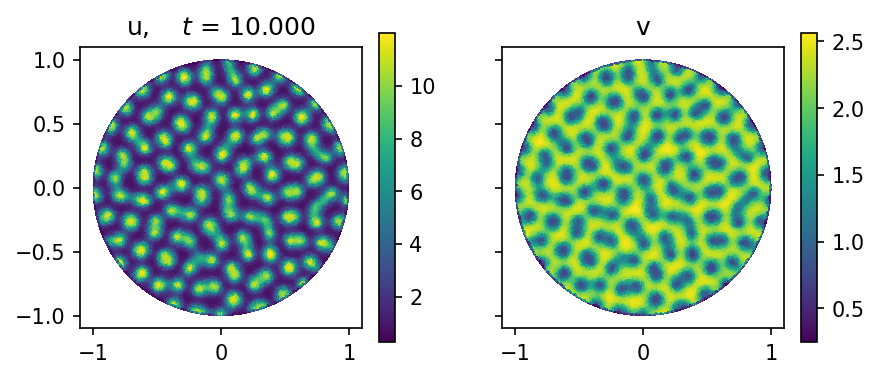

(<Figure size 900x450 with 4 Axes>,
 array([<Axes: title={'center': 'u,    $t$ = 10.000'}>,
        <Axes: title={'center': 'v'}>], dtype=object))

In [16]:
disp(mmesh2,gfu,10)  # worked but is not smooth and boundary does not look great
# still we could perhaps more easily make a movie this way by storing pngs than exporting vtks and using paraview